# Part I: Basics
## Basics of Parameter Estimation

This Notebook aims to introduce the basics of parameter estimation 
using "fits" with [`zfit`](https://github.com/zfit/zfit). 
We also use [`numpy`](https://numpy.org/) for data management and generation. 

This tutorial is based on materials originally developed for the [2022 LHCb Starterkit](https://github.com/schmitse/lhcb-starterkit-2022) by Sebastian Schmitt, and is used here with his permission. It was inspired by the great [tutorial from Hans at pyHEP](https://nbviewer.org/github/HDembinski/PyHEP-2022-iminuit/blob/main/iminuit.ipynb) and [Statistical Data Analysis](https://books.google.de/books/about/Statistical_Data_Analysis.html?hl=de&id=ff8ZyW0nlJAC&redir_esc=y) by Glen Cowan. Special thanks to **Jonas Eschle** for his work on [`zfit`](https://github.com/zfit/zfit), and to Lorenzo Paolucci, Gediminas Sarpis, and Dan Thompson for their contributions to the original material. 

## What zfit can do:

 - **Parameter estimation**, through minimisation of statistical cost functions
   - Binned and unbinned cost functions
   - Extended and not extended cost functions
   - Minimisation handled by [`(i)Minuit`](https://iminuit.readthedocs.io/en/stable/)
 - **Uncertainty estimation** of those parameters
 - Build complex **statistical models** to describe your data
 - Handle simple or more complex **parameter constraints**
 - **Sample** from the statistical models
 
## What zfit does not do:
 
  - **Visualise** the fit or the data, for this use [`matplotlib`](https://matplotlib.org/) or [`mplhep`](https://github.com/scikit-hep/mplhep). 
  - **Limit setting** or other **statistical methods**, for this see for example [`hepstats`](https://scikit-hep.org/hepstats/). 
  - **Data** preparation or selection, for this see [`numpy`](https://numpy.org/), [`pandas`](https://pandas.pydata.org/), or [`awkward`](https://github.com/scikit-hep/awkward). 
  
"Divide and Conquer", zfit aims to perform the operations described above and cooperate well with other libraries
that perform other operations, such as [`numpy`](https://numpy.org/), [`matplotlib`](https://matplotlib.org/), and others. Note for HEP physics, a nice interface between ROOT and python is given by [`uproot`](https://github.com/scikit-hep/uproot5).

## Why zfit and not RooFit?

[**RooFit**](https://root.cern/manual/roofit/) is a toolkit to perform fits integrated in ROOT that many in the HEP community use. However, if you work primarily in Python and don't rely on ROOT, **zfit offers several advantages**:

- **Python-first integration**: zfit is built for the Python ecosystem. This offers great interoperability with other python-based scientific/HEP packages.
- **Transparent**: zfit is more easily hackable and you have direct access to PDFs. For instance, creating custom models is as simple as inheriting from a base class and overriding methods using numpy-like syntax.
- **Pythonic plotting and outputs**: You can visualise fits with `matplotlib`, sample numpy-like arrays, and work with `hist` histograms naturally. This makes for a smooth, consistent workflow.
- **No ROOT dependency**: zfit doesn't require ROOT installation, which can sometimes cause compatibility issues with other Python packages.
- **Smooth learning curve**: For those coming from Python, zfit's interface feels more intuitive compared to learning ROOT/RooFit conventions.

At an introductory level, the concepts are similar between zfit and RooFit -- learning one prepares you for the other. This tutorial focuses on Python-only packages for a more cohesive, pythonic learning experience.

## Today

Hands on examples on:
 - How to run a simple fit
 - Visualise the fit
 - Explore why a fit may fail
 - Statistical background subtraction using the [$_{s}\mathcal{P}lot$ technique](https://arxiv.org/pdf/physics/0402083.pdf)
 - Simultaneous fitting to multiple datasets
 - Constraining parameters in the fit

In [1]:
import os
os.environ['ZFIT_DISABLE_TF_WARNINGS'] = '1'
# numpy is used for generating, storing, and plotting data
import numpy as np
# zfit will be used for the parameter estimation in the following
import zfit

# in order to visualise the results of the computation, we use matplotlib
import matplotlib as mpl
if os.path.exists('lhcbStylerc'):
    mpl.rc_file('lhcbStylerc') # some plotting presets I usually use, you can find them in the git-repo
    
import matplotlib.pyplot as plt
# for histograms boost has an easy api and is very fast
import hist
# for statistical distributions we can use a lot from scipy
from scipy import stats

## Parameter Estimation - General Concepts

Let $x$ be a **random variable** that follows a probability density function (**pdf**) $f(x)$. A set of $n$ measurements of $x$ is called a sample $\vec{x}$ of size $n$.

Consider the situation where we performed a measurement and obtained a sample $\vec{x}$ where the underlying pdf $f(x)$ is **unknown**. The central problem we will deal with today is to **infer properties** of the unknown pdf $f(x)$, given the measurement of the sample $\vec{x}$. 

Often there is a hypothesis for the unknown pdf $f(x|\vec{\vartheta})$ that depends on a **parameter** vector $\vec{\vartheta}$ in which case the problem boils down to trying to **infer the values** of the parameters $\vec{\vartheta}$. 

Today we will focus on parameter inference using the sample $\vec{x}$, which is called **parameter fitting**, using numerical methods. While easy examples of the methods we employ today may be solved analytically, generally numerical methods need to be used. 

## Setup

As an example, we will start by generating a random sample using `numpy` that follow a **normal distribution**. 

In [2]:
# create a sample with size 3000 that follow a normal distribution
zfit.settings.set_seed(1337)
gen = np.random.default_rng(seed=1337)
data = gen.normal(0, 1, size=(3000,))
# note, these are the maximum likelihood estimators for both the
# mean of a distribution and the variance (std = sqrt(variance))
print(f'Mean: {data.mean():.3f} Standard Dev.: {data.std(ddof=1):.3f}')

Mean: -0.006 Standard Dev.: 1.002



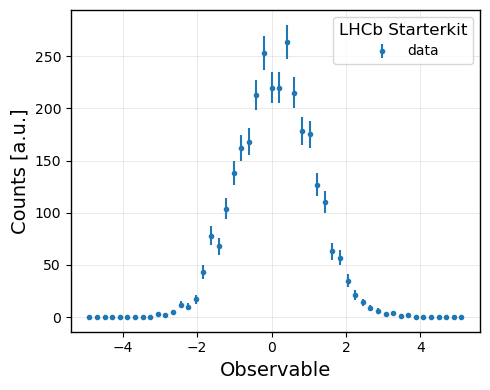

In [3]:
# convert data to histogram data
# we use np.histogram for this, later on we will also show examples with hist and matplotlib
y_hist, x_hist = np.histogram(data, bins=np.linspace(-5.1,5.1,51))
y_err = np.sqrt(y_hist)
x_err = np.diff(x_hist)
x_hist = x_hist[:-1] + x_err # place x_hist at the center of bins

plt.figure()
plt.errorbar(x_hist, y_hist, yerr=y_err, fmt='.', label='data')
plt.legend(loc='best', title='LHCb Starterkit', title_fontsize=12)
plt.xlabel('Observable')
plt.ylabel('Counts [a.u.]');

As expected, the data seem to follow a **normal** distribution. 
If we want to determine an estimate for the **centre** and **width** of the distributions we can either compute them as we did above through the arithmetic **mean** and empirical **standard deviation** or we may run a **fit**. 

## Fitting

For the fit we need:
 - An observable **space**
 - **Data** that is compatible with zfit
 - A **model** that describes the data
 - **Parameters** that control the model shape
 - The statistical **cost function**
 - A **minimiser** to optimise our cost function
 
Check the [**zfit documentation**](https://zfit.readthedocs.io/en/latest/user_api/index.html) if you're unsure about arguments!

In [4]:
# observable space
obs = zfit.Space('Observable', limits=(-5, 5))

# data in zfit
data_zfit = zfit.Data.from_numpy(obs=obs, array=data)
# note that zfit will crop the array given the limits of obs!

# parameters args: (name, starting value, minimum value, maximum value)
mu = zfit.Parameter("mu", data.mean(), -1, 1)
sigma = zfit.Parameter("sigma", data.std(ddof=1), 0.1, 2)
# model args: (observable space, zfit parameters, name)
model = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma, name='gaussian_model')

You can check all the pdfs that are implemented in the [**documentation**](https://zfit.readthedocs.io/en/latest/user_api/zfit.pdf.html). 

Some things you need to know when working with `zfit` `Parameter`s and `Model`s:

In [5]:
# in the terminal or in the notebooks, you can easily check 
# properties / functions of a parameter with tab:
# mu.

# a posteriori controlling floating / fixed attribute of parameter (more on this later)
mu.floating = True # False

# a posteriori controlling limits of parameter
mu.upper = 1 # None for no limit

# a posteriori setting the value of a parameter
mu.set_value(data.mean())
# can also be used with a context manager:
with mu.set_value(0.25):
    print(f'Within context manager: {mu.numpy():.2f}') ## -- +0.25
print(f'Outside context manager: {mu.numpy():.2f}')    ## -- -0.01

Within context manager: 0.25
Outside context manager: -0.01

Outside context manager: -0.01


In [6]:
# get the numerical value of the parameter (for other computations)
value_numpy = mu.numpy()
print(f'{type(value_numpy) = }, whereas \n{type(mu) = }')

# evaluate the pdf of a model on a basis
evaluation_basis = np.linspace(-1, 1, 10)

my_pdf = model.pdf(evaluation_basis) # this is a tensorflow (eager) tensor!
my_pdf_np = my_pdf.numpy()           # this is a numpy array!
print(f'\n{type(my_pdf) = }, whereas \n{type(my_pdf_np) = }\n')
print(my_pdf)
print(my_pdf_np)

type(value_numpy) = <class 'numpy.float64'>, whereas 
type(mu) = <class 'zfit.core.parameter.Parameter'>


type(my_pdf) = <class 'tensorflow.python.framework.ops.EagerTensor'>, whereas 
type(my_pdf_np) = <class 'numpy.ndarray'>

tf.Tensor(
[0.24337649 0.29592818 0.34255228 0.37748546 0.39601025 0.39549905
 0.3760255  0.34034705 0.2932645  0.24056356], shape=(10,), dtype=float64)
[0.24337649 0.29592818 0.34255228 0.37748546 0.39601025 0.39549905
 0.3760255  0.34034705 0.2932645  0.24056356]

type(my_pdf) = <class 'tensorflow.python.framework.ops.EagerTensor'>, whereas 
type(my_pdf_np) = <class 'numpy.ndarray'>

tf.Tensor(
[0.24337649 0.29592818 0.34255228 0.37748546 0.39601025 0.39549905
 0.3760255  0.34034705 0.2932645  0.24056356], shape=(10,), dtype=float64)
[0.24337649 0.29592818 0.34255228 0.37748546 0.39601025 0.39549905
 0.3760255  0.34034705 0.2932645  0.24056356]


## Cost Functions

There are different objectives, called **cost functions** in statistics, that may 
be optimised when trying to infer parameters from collected data. 
In physics, the most prominent objectives are motivated from the `Maximum Likelihood` (**ML**)
or the `Least Squares` (**LS**, also known as $\chi^2$) paradigms. For today, we will focus on the ML method. 

For a dataset $\vec{x}$, one can compute the **likelihood** of observing the data, given a 
probability density, $f(x|\vec{\vartheta})$, that may depend on model parameters $\vec{\vartheta}$. 
The maximum likelihood now aims to find the **parameters** $\hat{\vec{\vartheta}}$ under which the overall likelihood
$$
    \mathcal{L}(\vec{\vartheta}|\vec{x}) = \prod_i f(x_i|\vec{\vartheta})
$$
**is maximal**. Numerically, large products of numbers smaller than unity get small and unstable very quickly, hence one introduces the **(negative) log-likelihood**
$$
-\log{\mathcal{L}}(\vec{\vartheta}|\vec{x}) = - \log\left(\prod_i f(x_i|\vec{\vartheta})\right) = -\sum_i \log(f(x_i|\vec{\vartheta})),
$$
which behaves better. Due to the monotony of the logarithm, the maximum of $\log\mathcal{L}$ is equivalent to the maximum of $\mathcal{L}$. The minus sign is introduced to have a minimisation instead of a maximisation. 
For further reading on this i recommend one of the many great statistics books,
for example [**Statistical Data Analysis**](https://www.amazon.com/-/en/Glen-Cowan/dp/0198501552) by Glen Cowan. 

We want to focus on hands on examples for two types of ML fits today: `binned` and `unbinned` fits. 
Conceptually they differ in the way that the data are treated, 
as the name suggests the **binned** fits take a **histogram representation** of the data 
whereas the **unbinned** fits consider the **"raw"** data as input. 

Note: In machine learning the cost functions are often called `loss`. 

In [7]:
# the cost function
nll_unbinned = zfit.loss.UnbinnedNLL(model=model, data=data_zfit)

# Just like the Parameters and the models, the cost function "lives" in tensorflow
# you can check its current value for example with:
nll_value = nll_unbinned.value() # tensorflow tensor!
nll_value_np = nll_value.numpy() # numpy float 64!
print(f'{nll_value = }, whereas \n{nll_value_np = }')

# the minimiser
minimiser = zfit.minimize.Minuit(mode=1)

nll_value = <tf.Tensor: shape=(), dtype=float64, numpy=4261.88235388847>, whereas 
nll_value_np = 4261.88235388847



## Running the fit

We can run the minimisation of the cost function by calling `minimize` of the minimizer with the cost as argument. 
This calls the `migrad` algorithm of `Minuit`, which is a very robust and performant minimization algorithm. For a detailed description, see the [**Minuit paper**](https://www.sciencedirect.com/science/article/pii/0010465575900399?via%3Dihub). 

The `mode` option controls the minimization strategy used internally by `Minuit`, see [**their docs**](https://iminuit.readthedocs.io/en/stable/faq.html#what-happens-when-i-change-the-strategy). As a rule of thumb:
 - 0: The **fastest** fitting strategy. Scales linearly with number of parameters. Should be used for fits with high numbers of parameters. 
 - 1: The **default** strategy. Scales quadratically with number of parameters. More accurate determination of the second derivatives, therefore slower. 
 - 2: Scales quadratically with number of parameters. Slower than 1 because accurate hessian is computed at each step. 

In [8]:
# run the fit:
result = minimiser.minimize(nll_unbinned)
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-10 │             4261.88 |  10000 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu             -0.00583433       False
sigma               1.0017       False

## Visualising the Result

Lets start by defining a function to visualise the fit. 

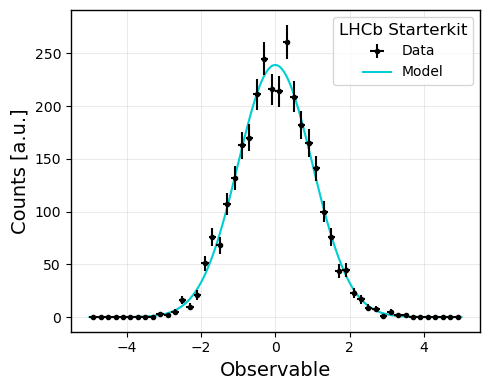

In [9]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=50, smodel: np.ndarray=None,
             drawstyle: str='default')->None:
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.volume.numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)
        
    # legend and axis labels
    ax.legend((art_data, art_model), ('Data', 'Model'), loc='best', 
              title='LHCb Starterkit', title_fontsize=12)
    ax.set_xlabel('Observable')
    ax.set_ylabel('Counts [a.u.]');
    
basis = np.linspace(-5, 5, 200)
model_np = model.pdf(basis).numpy() * data.shape[0]
plot_fit(data, basis, model_np, obs)

The fit looks good by eye, but lets inspect the fit result more closely:

In [10]:
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-10 │             4261.88 |  10000 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu             -0.00583433       False
sigma               1.0017       False

## Digesting the Result

We have performed our first fit! The results are compatible with the mean and standard dev. we computed above!
zfit tells us:
 - The **parameter** names and their **value** at the minimum
 - **Validity** of the minimum (see zfit documentation for this, access with `result.valid`)
 - Convergence status
 - If parameters have hit **boundaries**
 - The **EDM** (estimated distance to minimum, computed from first derivative $\vec{d}$ and covariance $\boldsymbol{V}$ as $\mathrm{EDM} = \vec{d}^{\rm T} \boldsymbol{V} \vec{d}$) 
 - The cost function value at the minimum

We can get even more information by inspecting the `info` of the result:

In [11]:
print(f'These keys are available: {result.info.keys()}')
print(f'Number of evaluations: {result.info["n_eval"]}')
print(f'Inverse hessian matrix: ')
print(result.info['inv_hessian'])
result.info['minuit']

These keys are available: dict_keys(['n_eval', 'minuit', 'original', 'inv_hessian'])
Number of evaluations: 26
Inverse hessian matrix: 

Number of evaluations: 26
Inverse hessian matrix: 
[[3.34472189e-04 6.68357577e-08]
 [6.68357577e-08 1.67266994e-04]]
[[3.34472189e-04 6.68357577e-08]
 [6.68357577e-08 1.67266994e-04]]


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1e+04                      │              Nfcn = 26               │
│ EDM = 3.13e-10 (Goal: 0.001)     │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │  -0.006   │   0.018   │            │            │   -1    │    1    │       │
│ 1 │ sigma │   1.002   │   0.013   │            │            │   0.1   │    2    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────┐
│       │       mu    sigma │
├───────┼───────────────────┤
│    mu │ 0.000334        0 │
│ sigma │        0 0.000167 │
└───────┴───────────────────┘

In jupyter notebooks, the `Minuit` object is rendered nicely, we see:
 - FCN, the cost function value at the minimum
 - **EDM**, the estimated distance to minimum (must be smaller than Goal for valid minimum)
 - **Nfcn**, the number of function calls 
 - Validity of the found minimum (check Minuit documentation for exact definition)
 - If parameters have hit a boundary
 - The status of the **covariance matrix**: accurate and positive definite, without being forced. (must be this for valid minimum)

There is more information regarding the parameters in the view from minuit:
 - Name of the parameter
 - **Value** at the minimum (rounded with **PDG rounding** rules)
 - **Hesse Error**, the standard symmetric uncertainty estimate from second derivatives (computed during minimisation in `migrad`)
 - **Minos Error**, the asymmetric uncertainty estimate based on likelihood profiling
 - The **covariance matrix** of the parameters

## Uncertainties

In order to determine the uncertainties at the best fit point, we can run the **hesse** algorithm.

### For the Statisticians

The `hesse` algorithm determines the uncertainties by calculating the second derivative of the $-\log{\mathcal{L}}$ at the best fit point. This is equivalent to determining the estimator of the variance of our estimator $\hat{\vec{\vartheta}}$ because of the ["RCF bound"](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound). The RCF bound is an inequality condition on the variance of an estimator $V[\hat{\vartheta}]$ which states that (for one parameter $\vartheta$)
$$ V[\hat{\vartheta}] \geq \left. \left(1 + \frac{\partial b}{\partial \vartheta}\right)^2 \right/ E\left[-\frac{\partial^2 \log\mathcal{L}}{\partial^2 \vartheta}\right],$$
with $b$ the bias of the estimator and $E$ being the expectation value. Since the ML method will find efficient estimators $\hat{\vartheta}$ (i.e. estimators with minimum variance), **if** they exist for a given problem, and they are often unbiased, the inequality reduces to
$$ \left(V\left[\hat{\vec{\vartheta}}\right]^{-1}\right)_{ij} = E\left[-\frac{\partial^2\log{\mathcal{L}}}{\partial\vartheta_i\partial\vartheta_j}\right]$$
under these assumptions. Note that while they are true in most cases, it is advised to check them!
This means the inverse of the second derivative of the $\log\mathcal{L}$ at the ML estimate for $\hat{\vec{\vartheta}}$ is the best estimate for the inverse variance of our estimator
$$ \left(\widehat{V\left[\hat{\vec{\vartheta}}\right]^{-1}}\right)_{ij} = \left.-\frac{\partial^2\log\mathcal{L}(\vec{\vartheta}|\vec{x})}{\partial\vartheta_i\partial\vartheta_j}\right|_{\vec{\vartheta}=\hat{\vec{\vartheta}}} .$$

This second derivative is what the `hesse` algorithm computes numerically. 

In [12]:
errs = result.hesse(name='minuit_hesse')
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-10 │             4261.88 |  10000 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    minuit_hesse    at limit
------  ------------------  --------------  ----------
mu             -0.00583433     +/-   0.018       False
sigma               1.0017     +/-   0.013       False

Now we also have the uncertainties from `hesse` in the zfit parameter view. You should **always rerun** `hesse` at the minimum!

In order to access the parameter values and uncertainties we can use the `params` object from the `result`. 
Here we find for all our parameters the 'value', and uncertainty information. 
The uncertainty field is saved under the method name (in our case `minuit_hesse`) that was given to the hesse call: 

In [13]:
pars = result.params
print(f'Keys of pars: {[k for k in pars.keys()]}')
print(f'Parameter mu: {pars["mu"]["value"]:.4f} +/- {pars["mu"]["minuit_hesse"]["error"]:.4f}')
print(f'Parameter sigma: {pars["sigma"]["value"]:.4f} +/- {pars["sigma"]["minuit_hesse"]["error"]:.4f}')

Keys of pars: [<zfit.Parameter 'mu' floating=True value=-0.005834>, <zfit.Parameter 'sigma' floating=True value=1.002>]
Parameter mu: -0.0058 +/- 0.0183
Parameter sigma: 1.0017 +/- 0.0129

Parameter mu: -0.0058 +/- 0.0183
Parameter sigma: 1.0017 +/- 0.0129


Asymmetric uncertainties on parameters can be determined using `minos`, which is based on likelihood profiling. 

### For the Statisticians

From the profile of the $-\log\mathcal{L}$ around the minimum one can obtain a measure of the variance of the estimator $V[\hat{\vartheta}]$, because of the following thought:

Around the minimum, $-\log\mathcal{L}$ can be taylor expanded to yield (for one parameter $\vartheta$)
$$ \log\mathcal{L}(\vartheta) = \log{\mathcal{L}}(\hat{\vartheta}) + \left[\frac{\partial\log\mathcal{L}(\vartheta)}{\partial\vartheta}\right]_{\vartheta=\hat{\vartheta}}(\vartheta-\hat{\vartheta}) + \frac{1}{2!}\left[\frac{\partial^2\log\mathcal{L}(\vartheta)}{\partial^2\vartheta}\right]_{\vartheta=\hat{\vartheta}}(\vartheta-\hat{\vartheta})^2 + \mathcal{O}\left((\vartheta-\hat{\vartheta})^3\right).$$
Omitting third order (and higher) terms and using the condition that the first derivative vanishes and identifying from before
$$ \left(\widehat{\sigma^2_{\hat{\vartheta}}}\right)^{-1} = -\left[\frac{\partial^2\log\mathcal{L}(\vartheta)}{\partial^2\vartheta}\right]_{\vartheta=\hat{\vartheta}},$$
we find that
$$ \log\mathcal{L}(\vartheta) = \log\mathcal{L}(\hat{\vartheta}) - \frac{(\vartheta-\hat{\vartheta})^2}{2\widehat{\sigma^2_{\hat{\vartheta}}}},$$
which we can evaluate at the point "$\hat{\vartheta}\pm\widehat{\sigma_{\hat{\vartheta}}}$", that coincides to the $\pm 1\sigma$ region
$$ \log\mathcal{L}\left(\hat{\vartheta}\pm\widehat{\sigma_{\hat{\vartheta}}}\right) = \log\mathcal{L}(\hat{\vartheta}) - \frac{1}{2}.$$

This means the best estimator for the square root of the variance of $\hat{\vartheta}$, $\widehat{\sigma_{\hat{\vartheta}}}$, is given by the intersection where the $-\log\mathcal{L}$ is 0.5 bigger than at the minimum. 

In [14]:
errs_minos = result.errors(method='minuit_minos', name='minuit_minos')
result

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-10 │             4261.88 |  10000 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    minuit_hesse         minuit_minos    at limit
------  ------------------  --------------  -------------------  ----------
mu             -0.00583433     +/-   0.018  -  0.018   +  0.018       False
sigma               1.0017     +/-   0.013  -  0.013   +  0.013       False

In this case the symmetric and asymmetric uncertainties yield the **same results**. 

Generally LHCb statistics guidelines prefer to report **symmetric uncertainties** for quantities unless the uncertainties obtained through minos are very asymmetric. 

## Visualising the Cost

`Minuit` offers a quick way to draw the cost function depending on the parameter in question:

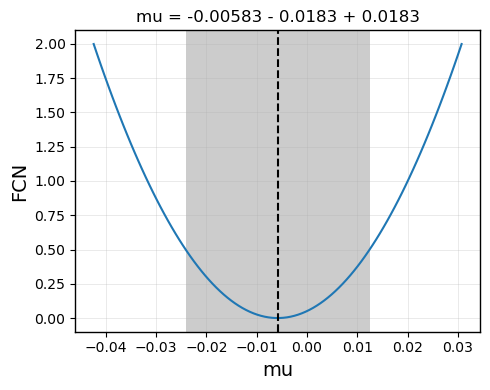

In [15]:
result.info['minuit'].draw_profile('mu');

This is now a simple profile of the cost when varying the parameter in question. 
The gray region visualises the $68\,\%$ confidence regions, i.e. the regions where the $-\log\mathcal{L}$ is 0.5 bigger than at the minimum. 

Generally this profile does **not** coincide with the uncertainties quoted by `hesse` or `minos`, because **correlations** alter the picture. For correct coverage, at each point the **cost needs to be minimised with respect to the nuisance parameters** (all other parameters that arent fixed) in order to obtain the correct profile. 

Also for this `Minuit` offers a quick way to draw the correct contour. This is only possible after having run `minos` and is computationally more expensive: 

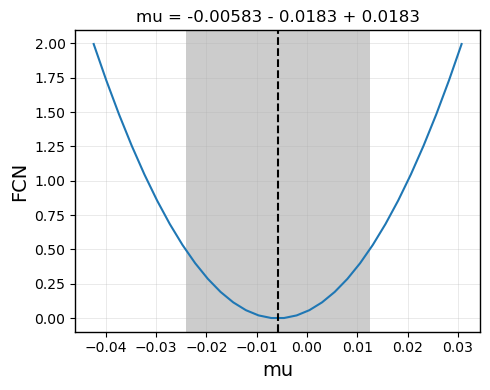

In [16]:
result.info['minuit'].draw_mnprofile('mu');

Also two dimensional profiles of the likelihood are quickly draw-able with `Minuit`. 
Note the small correlations in our fit to the normal distribution. 

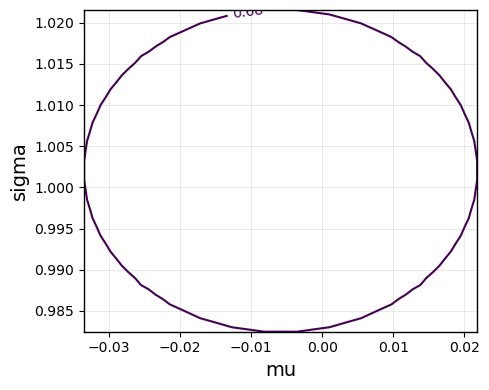

In [17]:
result.info['minuit'].draw_mncontour('mu', 'sigma');

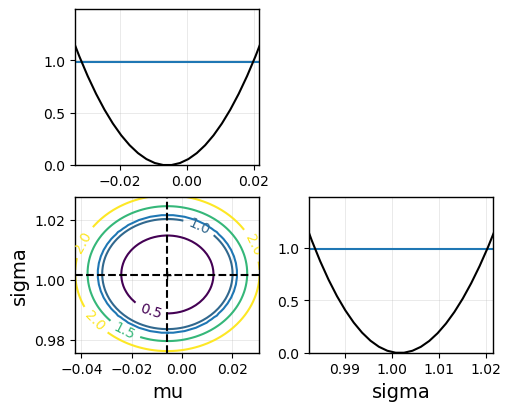

In [18]:
# draw a nice covariance matrix from minos with this (time consuming)
result.info['minuit'].draw_mnmatrix();

# a profile without minimisation at each point can be drawn with contour:
result.info['minuit'].draw_contour('mu', 'sigma');

## Visualising the Uncertainties

One can propagate the uncertainties on the individual parameters to the lineshape of the model in the visualisation. 
For this we cannot simply "shift" all parameters according to their uncertainties as this would again not reflect on correlations of the parameters. 

Instead we need to **correctly propagate** the uncertainties to the lineshape. This is possible in multiple ways and i will show you the **bootstrapping** approach. For this we sample random numbers from the multivariate normal distribution that we obtained from the fitter and evaluate the model for each random sample. 
The uncertainty on the model at each point is then given by the empirical standard deviation of the ensemble of models:

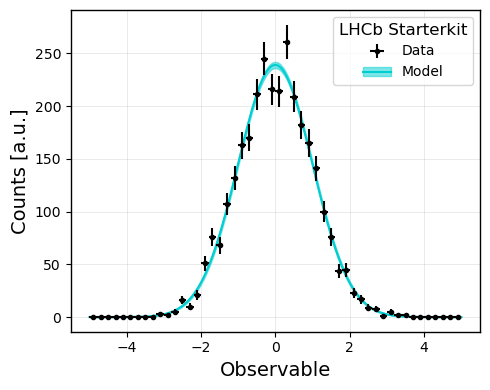

In [19]:
# get the vector of means for the mv. gaussian and the covariance
mean_params = [result.params[p]['value'] for p in result.params.keys()]
covariance = result.covariance()
# generate the random combinations of mu and sigma 
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)

# evaluate the model at each point of the basis for all parameters that were previously sampled
# then take the standard deviation along the basis axis for all elements in the 2-D array
# Note: List comprehension may look hacky at times but its fast!
smodels_np = np.std([stats.norm.pdf(basis, loc=_mu, scale=_sigma) * data.shape[0] 
                     for _mu, _sigma in rnd_pars], ddof=1, axis=0)

# visualise the uncertainty:
plot_fit(data, basis, model_np, obs, smodel=smodels_np)

## Fixed Parameters

So far we have had all parameters (`mu` and `sigma`) float freely during the fitting process. If for whatever reason you wish to fix a parameter (e.g. `mu`), you can do this either upon creation of the parameter or afterwards.

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-10 │             4261.88 |  10000 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
sigma               1.0017       False
 of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('Observable',) shape=(3000, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤═════════

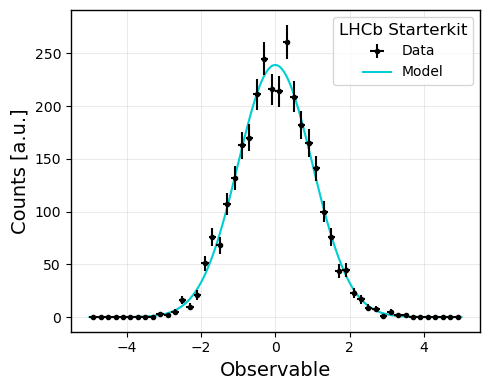

In [20]:
# observable space
obs_fixedmu = zfit.Space('Observable', limits=(-5, 5))

# data in zfit
data_zfit_fixedmu = zfit.Data.from_numpy(obs=obs_fixedmu, array=data)

mu_fixedmu = zfit.Parameter("mu", data.mean(), floating  = False) # No need to give bounds in this case
# Alternatively, as we've seen before, you can fix parameters after creation:
# mu_fixedmu = zfit.Parameter("mu", data.mean(), -1, 1)
# mu_fixedmu.floating = True # False

sigma_fixedmu = zfit.Parameter("sigma", data.std(ddof=1), 0.1, 2)
# model args: (observable space, zfit parameters, name)
model_fixedmu = zfit.pdf.Gauss(obs=obs, mu=mu_fixedmu, sigma=sigma_fixedmu, name='gaussian_model')

# the cost function
nll_unbinned_fixedmu = zfit.loss.UnbinnedNLL(model=model_fixedmu, data=data_zfit_fixedmu)
# run the fit:
result = minimiser.minimize(nll_unbinned_fixedmu)
print(result)

model_np_fixedmu = model_fixedmu.pdf(basis).numpy() * data.shape[0]
plot_fit(data, basis, model_np_fixedmu, obs_fixedmu)

As we can see from the output Parameters output table, only `sigma` appears now since `mu` is fixed.

## Binned Fits

It is also possible to fit **binned datasets** in zfit. For this we need:
 - Create a binned space
 - Create a binned dataset
 - Create a binned model
 - Create a binned loss
 - Run the minimisation

In [21]:
# Binned space needs to have binning information
obs_binned = zfit.Space('Observable', limits=(-5, 5), binning=50)

# we can create a binned dataset from the unbinned one by specifying the space
data_zfit_binned = data_zfit.to_binned(obs_binned)

# binned model from our unbinned model
model_binned = zfit.pdf.BinnedFromUnbinnedPDF(model, obs_binned)

# binned likelihood cost function
nll_binned = zfit.loss.BinnedNLL(model_binned, data_zfit_binned)

# run the minimisation
result_binned = minimiser.minimize(nll_binned)

# perform uncertainty determination
result_binned.hesse(name='minuit_hesse')
result_binned.errors(method='minuit_minos', name='minuit_minos')
result_binned

FitResult of
<BinnedNLL model=[<zfit.models.tobinned.BinnedFromUnbinnedPDF object at 0x34765ebc0>] data=[<zfit._data.binneddatav1.BinnedData object at 0x34703ead0>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 2.6e-07 │           117.52 |  9996.565 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    minuit_hesse         minuit_minos    at limit
------  ------------------  --------------  -------------------  ----------
mu             -0.00381309     +/-   0.018  -  0.018   +  0.018       False
sigma               1.0028     +/-   0.013  -  0.013   +  0.013       False

## Fixed Parameters

So far we have had all parameters (mu and sigma) float freely during the fitting process. If for whatever reason you wish to fix a parameter

### For the Statisticians

The binned ML is defined by integrating the pdf over the bin range, which yields the expectation for the number of entries $\nu_i$ in a bin $b_i$
$$ \nu_i(\vec{\vartheta}) = \int_{b_i^{\rm low}}^{b_i^{\rm up}} f(x|\vec{\vartheta})dx.$$

The sample of size $N$ which we previously called $\vec{x}$ got converted to a histogram with entries $n_i$ in bin $b_i$ and the joint pdf of observing the histograms counts given the expectation $\nu_i(\vartheta)$ is given by a multinomial distribution
$$ \mathcal{L}^{\rm binned}(\vec{\vartheta}|\vec{x}) = \frac{N!}{\prod_{i=1}^{N_{b}} n_i!} \prod_{i=1}^{N_b} \left(\frac{\nu_i(\vec{\vartheta})}{N}\right)^{n_i}.$$
The negative log likelihood is therefore given by
$$ -\log\mathcal{L}^{\rm binned}(\vec{\vartheta}|\vec{x}) = -\sum_{i=1}^{N_b} n_i \log{\nu_i(\vec{\vartheta})} + \mathrm{const}.$$

## Differences of Binned and Unbinned Fits

There are some small differences between the binned and the unbinned fits. This is mainly motivated by the **different** (less) **information** that the binned fit can access compared to the unbinned one. The more bins a binned fit uses, the closer the fit result of the unbinned and binned fits usually become. 

In [22]:
print('Results from unbinned fit: ')
print([result.params[p]['value'] for p in result.params.keys()])
print('Results from binned fit: ')
print([result_binned.params[p]['value'] for p in result_binned.params.keys()])

Results from unbinned fit: 
[1.0016990028033865]
Results from binned fit: 
[-0.0038130870909312, 1.0027960186908558]

[1.0016990028033865]
Results from binned fit: 
[-0.0038130870909312, 1.0027960186908558]


/var/folders/23/5n_ndwdj5dq02zybdsm8cpkr0000gq/T/ipykernel_10240/2970735112.py:2: DeprecationWarning: area (from zfit.core.space) is deprecated and will be removed in a future version.
Instructions for updating:
Use the `volume` attribute instead (don't call it, i.e. convert `space.area()` to `space.volume`.
  model_np_binned = model_binned.values().numpy() * data.shape[0] / obs_binned.area() * 50


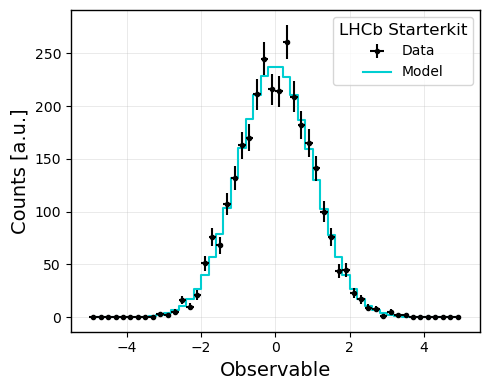

In [23]:
basis_binned = model_binned.axes.centers[0]
model_np_binned = model_binned.values().numpy() * data.shape[0] / obs_binned.area() * 50

# steps-mid yields the usual histogram draw style
plot_fit(data, basis_binned, model_np_binned, obs_binned, drawstyle='steps-mid')

## Composite Models

In real life, usually the data we deal with is not described by a "simple" gaussian but also features some backgrounds that pollute the data in the signal region. 
In the case that one can make assumptions about the shape of the background distribution we can fit the combined background and signal shape to the data. 

In `zfit` this functionality is implemented by the ability to "add" up different models. It can be done with **fractions** of the respective model with respect to all or with **extended models**. Extended models are models that have a "**yield**" associated to them. 

In [24]:
# background from exponential + gaussian for signal
data_gauss = gen.normal(0.5, 0.1, size=(3000,))
data_exp = gen.exponential(0.4, size=(5000,))
data_all = np.append(data_gauss, data_exp)

# new observable and zfit data
obs_bkg = zfit.Space('Observable with Background', limits=(0, 1))
data_zfit = zfit.Data.from_numpy(obs=obs_bkg, array=data_all)

# parameters for signal and background shapes
mu_signal = zfit.Parameter('mu_signal', 0.5, 0.2, 0.8)
sigma_signal = zfit.Parameter('sigma_signal', 0.1, 1e-4, 1)

# be careful and check the documentation. numpy and in zfit there are
# different definitions of the slope parameter in use! 
# numpy: exp(-x/slope) zfit: exp(slope*x)
slope_bkg = zfit.Parameter('slope_bkg', -0.4e-1, -10, 0.1)

# yields for an extended fit
n_signal = zfit.Parameter('n_signal', 3000, 0, 9000)
n_bkg = zfit.Parameter('n_bkg', data_zfit.n_events.numpy()-3000, 0, 9000)

# create the pdfs with the extended term for the yields
gaussian = zfit.pdf.Gauss(obs=obs_bkg, mu=mu_signal, sigma=sigma_signal, name='Signal')
gaussian_ext = gaussian.create_extended(n_signal)

exponential = zfit.pdf.Exponential(obs=obs_bkg, lam=slope_bkg, name='Background')
exponential_ext = exponential.create_extended(n_bkg)

# build the model as the sum of the gaussian and the exponential functions
model = zfit.pdf.SumPDF([gaussian_ext, exponential_ext])

# SumPDF with fraction instead of yield parameters (alternative to defining n_signal and n_bkg)
# frac = zfit.Parameter('frac', 0.5, 0.1, 0.9)
# model = zfit.pdf.SumPDF([gaussian, exponential], fracs=[frac])

# loss function is now extended unbinned NLL
nll_ext = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data_zfit)

### For the Statisticians

We now need to build an extended negative log likelihood, since we changed the normalisation of the models to be a parameter of interest. So the extended likelihood is now given by the product of the probability of observing $n$ candidates in the data given that $\nu$ is the mean of the underlying poisson distribution and the usual likelihood
$$ \mathcal{L}^{\rm ext.}(\vec{\vartheta}|\vec{x}) = \frac{e^{-\nu}}{n!} \prod_{i=1}^{n} \nu f(x_i|\vec{\vartheta}).$$
Consequently the extended negative log likelihood is given by
$$ -\log{\mathcal{L}^{\rm ext.}}(\vec{\vartheta}|\vec{x}) = -n\log{\nu} + \nu - \sum_{i=1}^{n}\log f(x_i|\vec{\vartheta}) + \mathrm{const} = \nu - \sum_{i=1}^{n} \log\left(\nu f(x_i|\vec{\vartheta})\right) + \mathrm{const}.$$

In [25]:
result_ext = minimiser.minimize(nll_ext)
result_ext.hesse(name='minuit_hesse')
result_ext.errors(method='minuit_minos', name='minuit_minos')
result_ext

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.Data: Data obs=('Observable with Background',) shape=(7571, 1)>] constraints=[]> 
with
<Minuit Minuit, tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00042 │         -1580.78 |  9045.309 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)    minuit_hesse         minuit_minos    at limit
------------  ------------------  --------------  -------------------  ----------
n_signal                 2992.74     +/-      95  -     92   +     98       False
n_bkg                     4578.2     +/-   1e+0

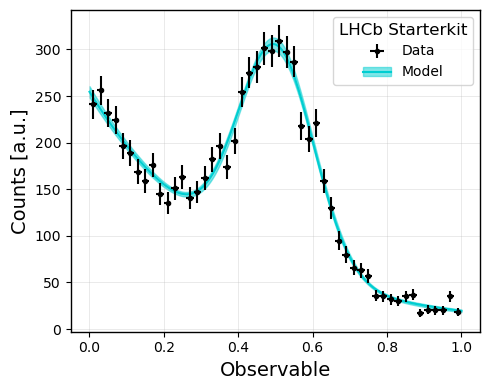

In [26]:
# visualise as we have discussed before
# with the addition of this helper function for the uncertainties
def eval_zfit_model(model: zfit.pdf.BasePDF, basis:np.ndarray, pars: np.ndarray)->np.ndarray:
    """ brief helper to evaluate model for given parameters and basis """
    with zfit.param.set_values([n_signal, n_bkg, mu_signal, sigma_signal, slope_bkg], pars):
        pdf = model.pdf(basis) * (n_signal.numpy()+n_bkg.numpy())
    return pdf

# the model as the sum of the individual pdfs
basis_pdf = np.linspace(0, 1, 200)
model_pdf_np = model.pdf(basis_pdf).numpy() * (n_signal.numpy()+n_bkg.numpy())

# the uncertainty computation on our model given the parameters
mean_params = [result_ext.params[p]['value'] for p in result_ext.params.keys()]
covariance = result_ext.covariance()
rnd_pars = gen.multivariate_normal(mean_params, covariance, 200,)
smodel_pdf_np = np.std([eval_zfit_model(model, basis_pdf, pars) for pars in rnd_pars], ddof=1, axis=0)

# plotting all together
plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np)

With just a few modifications to the plotting script we can also visualise the sub-models of our composed model: 

In [27]:
print([m for m in model.get_models()])

[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu_signal, sigma_signal], <zfit.<class 'zfit.models.basic.Exponential'>  params=[slope_bkg, slope_bkg]]



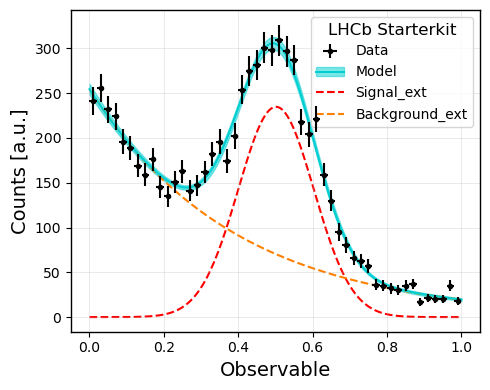

In [28]:
def plot_fit(dat: np.ndarray, basis: np.ndarray, model: np.ndarray, 
             obs: zfit.Space, nbins : int=50, smodel: np.ndarray=None,
             drawstyle: str='default', zmodel: zfit.pdf.BasePDF=None):
    """
    quick plotting function to visualise data and model. 
    Takes:
     - dat: (array) the data that are fitted
     - basis: (array) the points at which the model is evaluated
     - model: (array) the model that describes the data
     - obs: (zfit Space) the space in which the model lives
     - nbins: (int) the number of bins for the data histogram
     - smodel: (array) uncertainty on model (not needed)
     - drawstyle: (str) the drawstyle of plt.plot
     - zmodel: (BasePDF) for drawing submodels
    Returns:
     - None
    """
    # for normalising the pdf, scaled pdf = pdf * yield * area / bins
    limits = obs.limits 
    area = obs.area().numpy()

    # data in histogram over the full observable space
    histo = hist.Hist(hist.axis.Regular(nbins, *limits))
    histo.fill(dat)

    # the figure with an errorbar for the data and a line for the model
    fig, ax = plt.subplots()
    art_data = ax.errorbar(histo.axes.centers[0], histo.values(), 
                           xerr=histo.axes.widths[0]/2,
                           yerr=np.sqrt(histo.values()), fmt='.', 
                           label='Data', color='black', zorder=10)
    art_model = ax.plot(basis, model * area/nbins, color='darkturquoise', 
                        label='Model', zorder=8, drawstyle=drawstyle)[0]
    
    # if we have the uncertainty on the model we draw it as contour
    # and update the artist for the legend to reflect on the new model
    if smodel is not None:
        _art = ax.fill_between(basis, (model+smodel)*area/nbins, 
                               (model-smodel)*area/nbins, color='darkturquoise', 
                               alpha=0.5, zorder=-2)
        art_model = (art_model, _art)

    # define artists and labels for the legend
    artists = [art_data, art_model]
    labels = ['Data', 'Model']
    # if we want to plot the submodels of our model, we can iterate through
    # all of them and evaluate them at our basis. We will not bootstrap
    # all of their shape uncertainties though, this is just an illustration
    if hasattr(zmodel, 'get_models'):
        nmodels = len(zmodel.get_models())
        cmap = plt.get_cmap('autumn') # you can choose whatever you like. 
        norm = mpl.colors.Normalize(0, nmodels) # create a norm for the cmap
        pdfs = [(m.pdf(basis)*m.get_yield()).numpy()*area/nbins
                for m in zmodel.get_models()]
        names = [m.name.replace('_extended','') for m in zmodel.get_models()]
        labels.extend(names)
        for mdex, pdf in enumerate(pdfs):
            artists.append(ax.plot(basis, pdf, color=cmap(norm(mdex)), 
                                   linestyle='--', zorder=-1)[0])
        
    # legend and axis labels
    ax.legend(artists, labels, loc='best', 
              title='LHCb Starterkit', title_fontsize=12)
    ax.set_xlabel('Observable')
    ax.set_ylabel('Counts [a.u.]');

plot_fit(data_all, basis_pdf, model_pdf_np, obs_bkg, smodel=smodel_pdf_np, zmodel=model)

## Recap

What we have done so far:
 - Perform fit to dataset (binned, unbinned, and extended)
 - Understand the result of the fit
 - Visualised fits with uncertainties
 - Visualised cost function dependence on parameters

The next part focuses on why a fit may fail but now lets head to the..
# Coffee-Break